# Spotify Analysis

Spotify generates its summary "Spotify Wrapped" at every end of the year. The goal of this project is to reproduce my insights using Python, pandas, and data visualization.  
To do so, I extract my user data from Spotify for my streaming history.

# Import Libaraies and Setting Up the Environment
In this section, I import all the packages that will be used later.

In [1]:
# Import all relevant Python packages

# Data import & processing
import pandas as pd 
import numpy as np
import glob
import os
import json
import string


# Packages for Dates
from datetime import datetime
from pytz import timezone

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn
pn.extension('tabulator')
import hvplot.pandas 

# Import my data

I received my Spotify data in different batches (total of 9 JSON files). I aim to import all of them at once in a Pandas dataframe

In [2]:
# My local path
path_to_json = '/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2' 
json_pattern = os.path.join(path_to_json, 'Streaming_History_Audio_*.json')

#listing all the streaming music history JSON files paths
globbed_files = glob.glob(json_pattern) 
globbed_files

['/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Streaming_History_Audio_2023_1.json',
 '/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Streaming_History_Audio_2023_0.json',
 '/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Streaming_History_Audio_2024_8.json',
 '/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Streaming_History_Audio_2023-2024_5.json',
 '/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Streaming_History_Audio_2024_7.json',
 '/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Streaming_History_Audio_2023_4.json',
 '/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Streaming_History_Audio_2024_6.json',
 '/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Streaming_History_Audio_2023_3.json',
 '/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Streaming_History_Audio_2023_2.json',
 '/Users/Aprxx/Desktop/Project/Spotify Ex

In [3]:
all_data = []
for json in globbed_files:
    frame= pd.read_json(json)
    frame['filename']=os.path.basename(json)
    all_data.append(frame)

# Convert to a dataframe
df= pd.concat(all_data, ignore_index=True)

# Save the data
compiled_csv_path = os.path.join(path_to_json,"Compiled_StreamingHistory.csv")
# Save as CSV
df.to_csv(compiled_csv_path,index=False)

# Preprocess My Data

In [4]:
spotify_data = pd.read_csv("/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Compiled_StreamingHistory.csv")

# Remove private inofrmation
spotify_data.drop('ip_addr', axis=1, inplace =True)

print(spotify_data)

/var/folders/r9/8p1x2gzj1gz1w25st7y29mdh0000gn/T/ipykernel_3399/2444530316.py:1: DtypeWarning: Columns (12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  spotify_data = pd.read_csv("/Users/Aprxx/Desktop/Project/Spotify Extended Streaming History 2/Compiled_StreamingHistory.csv")


                          ts platform  ms_played conn_country  \
0       2023-04-07T16:11:19Z      ios       3670           US   
1       2023-04-07T16:11:23Z      ios       3940           US   
2       2023-04-07T16:11:27Z      ios       4100           US   
3       2023-04-07T16:11:31Z      ios       3860           US   
4       2023-04-07T16:11:34Z      ios       2420           US   
...                      ...      ...        ...          ...   
155437  2025-02-28T19:48:00Z      ios     117996           US   
155438  2025-02-28T19:55:37Z      ios     151949           US   
155439  2025-02-28T21:32:11Z      ios      39939           US   
155440  2025-02-28T22:23:13Z      osx     351083           US   
155441  2025-02-28T22:26:43Z      osx     209106           US   

        master_metadata_track_name master_metadata_album_artist_name  \
0                           JIKJIN                          TREASURE   
1                         GAM3 BO1                         SEVENTEEN   
2  

In [5]:
# Display missing values per column
spotify_data.isnull().sum()

ts                                        0
platform                                  0
ms_played                                 0
conn_country                              0
master_metadata_track_name              779
master_metadata_album_artist_name       779
master_metadata_album_album_name        823
spotify_track_uri                       779
episode_name                         154778
episode_show_name                    154778
spotify_episode_uri                  154778
audiobook_title                      155327
audiobook_uri                        155327
audiobook_chapter_uri                155327
audiobook_chapter_title              155330
reason_start                              0
reason_end                                0
shuffle                                   0
skipped                                   0
offline                                   0
offline_timestamp                         0
incognito_mode                            0
filename                        

There are nul values for track names. The reason is that some of the streaming history are not music, but podcasts or audiobooks. Since I'm only analyzing my music history, I'm going to drop the null values and irrelevant columns.

In [ ]:
# Drop columns that relate to podcasts or audiobooks
spotify_data= spotify_data[spotify_data['master_metadata_album_album_name'].notnull()]
spotify_data = spotify_data.drop(
    columns=[
        'episode_name',
        'episode_show_name',
        'spotify_episode_uri',
        'audiobook_title',
        'audiobook_uri',
        'audiobook_chapter_uri',
        'audiobook_chapter_title'
    ]
)
spotify_data.isnull().sum()

ts                                   0
platform                             0
ms_played                            0
conn_country                         0
master_metadata_track_name           0
master_metadata_album_artist_name    0
master_metadata_album_album_name     0
spotify_track_uri                    0
reason_start                         0
reason_end                           0
shuffle                              0
skipped                              0
offline                              0
offline_timestamp                    0
incognito_mode                       0
filename                             0
dtype: int64

After this cleaning, my dataset becomes much more reliable for analyzing music streaming history.

# Add Variables
I will add variables for better analysis, including **durations and time.**

In [ ]:
# Add variables for duration (seconds and minutes)
spotify_data['sec_played']= round(spotify_data['ms_played']/1000,4)
spotify_data['minute_played']= round(spotify_data['sec_played']/60,2)

As I have traveled to different places in the past, I will transform the timezones to **Pacific Timezone** based on these countries.

In [8]:
# Check unique value in country
dif_country = spotify_data['conn_country'].unique()
print(dif_country)

['US' 'KR' 'HK' 'CN' 'SG' 'TH' 'IN' 'TW' 'JP']


In [9]:
# Transfer timezone to Pacific Timezone
spotify_data["timestamp"] = pd.to_datetime(spotify_data["ts"], utc=True)

# Define a function to convert timestamp based on conn_country and date conditions
def convert_timestamp(row):
    country = row['conn_country']
    if country == "US":
        if row["timestamp"] < pd.Timestamp("2024-12-01", tz='UTC'):
            target_tz = "America/Chicago"
        else:
            target_tz = "America/Los_Angeles"
    elif country == "KR":
        target_tz = "Asia/Seoul"
    elif country in ["HK", "CN", "TW"]:
        target_tz = "Asia/Shanghai"
    elif country == "SG":
        target_tz = "Asia/Singapore"
    elif country == "TH":
        target_tz = "Asia/Bangkok"
    elif country == "IN":
        target_tz = "Asia/Kolkata"
    elif country == "JP":
        target_tz = "Asia/Tokyo"
    else:
        target_tz = "UTC"
    
    # Return the timezone-converted datetime
    return row["timestamp"].tz_convert(target_tz)



# Apply the conversion function row-wise to create a new column with the target timezone
spotify_data["timestamp_target"] = spotify_data.apply(convert_timestamp, axis=1)

In [10]:
# Add Time Variables
spotify_data['year']  = spotify_data['timestamp_target'].apply(lambda x: x.strftime('%Y'))
spotify_data['month'] = spotify_data['timestamp_target'].apply(lambda x: x.strftime('%Y-%m'))
spotify_data['date']  = spotify_data['timestamp_target'].apply(lambda x: x.strftime('%Y-%m-%d'))
spotify_data['time']  = spotify_data['timestamp_target'].apply(lambda x: x.strftime('%H:%M'))


In [11]:
# Rename variables
spotify_data = spotify_data.rename(columns = {'master_metadata_track_name': 'track_name',
                                              'master_metadata_album_artist_name':'artist_name',
                                              'master_metadata_album_album_name':'album_name'})

# Results
spotify_data.sort_values('ts', ascending = False)

,ts,platform,ms_played,conn_country,track_name,artist_name,album_name,spotify_track_uri,reason_start,reason_end,...,incognito_mode,filename,sec_played,minute_played,timestamp,timestamp_target,year,month,date,time
155441,2025-02-28T22:26:43Z,osx,209106,US,Cool Cat - Remastered 2011,Queen,Hot Space,spotify:track:6Re2AwZUVlgBng04BZTauW,trackdone,trackdone,...,False,Streaming_History_Audio_2024-2025_9.json,209.106,3.49,2025-02-28 22:26:43+00:00,2025-02-28 14:26:43-08:00,2025,2025-02,2025-02-28,14:26
155440,2025-02-28T22:23:13Z,osx,351083,US,ExtraL (feat. Doechii),JENNIE,ExtraL (feat. Doechii),spotify:track:7AKwWqnoMmvCqBQtcdIECG,clickrow,trackdone,...,False,Streaming_History_Audio_2024-2025_9.json,351.083,5.85,2025-02-28 22:23:13+00:00,2025-02-28 14:23:13-08:00,2025,2025-02,2025-02-28,14:23
155439,2025-02-28T21:32:11Z,ios,39939,US,ExtraL (feat. Doechii),JENNIE,ExtraL (feat. Doechii),spotify:track:7AKwWqnoMmvCqBQtcdIECG,remote,logout,...,False,Streaming_History_Audio_2024-2025_9.json,39.939,0.67,2025-02-28 21:32:11+00:00,2025-02-28 13:32:11-08:00,2025,2025-02,2025-02-28,13:32
155438,2025-02-28T19:55:37Z,ios,151949,US,ExtraL (feat. Doechii),JENNIE,ExtraL (feat. Doechii),spotify:track:7AKwWqnoMmvCqBQtcdIECG,appload,remote,...,False,Streaming_History_Audio_2024-2025_9.json,151.949,2.53,2025-02-28 19:55:37+00:00,2025-02-28 11:55:37-08:00,2025,2025-02,2025-02-28,11:55
155437,2025-02-28T19:48:00Z,ios,117996,US,ExtraL (feat. Doechii),JENNIE,ExtraL (feat. Doechii),spotify:track:7AKwWqnoMmvCqBQtcdIECG,fwdbtn,unexpected-exit-while-paused,...,False,Streaming_History_Audio_2024-2025_9.json,117.996,1.97,2025-02-28 19:48:00+00:00,2025-02-28 11:48:00-08:00,2025,2025-02,2025-02-28,11:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16301,2023-01-29T21:57:38Z,ios,1813,US,911,Lady Gaga,Chromatica,spotify:track:6qI0MU175Dk2DeoUjlrOpy,fwdbtn,fwdbtn,...,False,Streaming_History_Audio_2023_0.json,1.813,0.03,2023-01-29 21:57:38+00:00,2023-01-29 15:57:38-06:00,2023,2023-01,2023-01-29,15:57
16300,2023-01-29T21:57:37Z,ios,2709,US,Levitating (feat. DaBaby),Dua Lipa,Levitating (feat. DaBaby),spotify:track:463CkQjx2Zk1yXoBuierM9,clickrow,fwdbtn,...,False,Streaming_History_Audio_2023_0.json,2.709,0.05,2023-01-29 21:57:37+00:00,2023-01-29 15:57:37-06:00,2023,2023-01,2023-01-29,15:57
16299,2023-01-29T21:57:34Z,ios,1109,US,Don't Trust Me,the booyah! kids,Booyah,spotify:track:5xz9GcQI6wDVjSFneT8J6n,backbtn,endplay,...,False,Streaming_History_Audio_2023_0.json,1.109,0.02,2023-01-29 21:57:34+00:00,2023-01-29 15:57:34-06:00,2023,2023-01,2023-01-29,15:57
16298,2023-01-29T21:57:30Z,ios,2282,US,Born To Die,Lana Del Rey,Born To Die – Paradise Edition,spotify:track:5wEreUfwxZxWnEol61ulIi,backbtn,backbtn,...,False,Streaming_History_Audio_2023_0.json,2.282,0.04,2023-01-29 21:57:30+00:00,2023-01-29 15:57:30-06:00,2023,2023-01,2023-01-29,15:57


# Understand the data

Check the number of songs and date range in each file.

In [12]:
# Group by 'filename' and compute the aggregations
volumetry_file = spotify_data.groupby('filename').agg(
    min_date = ('date', 'min'),
    max_date = ('date', 'max'),
    total_tracks = ('spotify_track_uri','count'),

).reset_index()

# Order the result by the minimum date
volumetry_file = volumetry_file.sort_values('min_date')

# Display the result
print(volumetry_file)


                                   filename    min_date    max_date  \
1       Streaming_History_Audio_2023_0.json  2023-01-29  2023-04-07   
2       Streaming_History_Audio_2023_1.json  2023-04-07  2023-06-13   
3       Streaming_History_Audio_2023_2.json  2023-06-13  2023-07-29   
4       Streaming_History_Audio_2023_3.json  2023-07-29  2023-09-12   
5       Streaming_History_Audio_2023_4.json  2023-09-12  2023-12-21   
0  Streaming_History_Audio_2023-2024_5.json  2023-12-21  2024-03-07   
7       Streaming_History_Audio_2024_6.json  2024-03-07  2024-05-23   
8       Streaming_History_Audio_2024_7.json  2024-05-23  2024-09-16   
9       Streaming_History_Audio_2024_8.json  2024-09-16  2024-12-02   
6  Streaming_History_Audio_2024-2025_9.json  2024-12-02  2025-02-28   

   total_tracks  
1         16283  
2         16286  
3         16339  
4         16320  
5         16128  
0         16217  
7         16110  
8         15585  
9         16002  
6          9349  


In total, I have 9 JSON files from Spotify. The time range starts from 2023-01-29 to 2025-02-28.

# Data Analysis

### Total Tracks & Total Minutes  
In this session, I will review total tracks and total minutes I streamed on Spotify each year.  
### Unique Tracks & Unique Artists  
I will dive into new artists or tracks that I explore each year.

In [ ]:
# Group the data by year
agg = spotify_data.groupby('year').agg(
    total_tracks = ('spotify_track_uri','count'),
    total_minutes = ('minute_played','sum'),
    unique_artist = ('artist_name', pd.Series.nunique), #Count of new artists
    unique_track = ('spotify_track_uri', pd.Series.nunique)    # Count of new tracks
)

# Convert minutes to hours
agg['total_hours']= round(agg['total_minutes']/60,2) 

# Approximate hours played per day
agg['hours_per_day']= round(agg['total_hours']/365 ,2) 


# Display result
agg

,total_tracks,total_minutes,unique_artist,unique_track,total_hours,hours_per_day
year,,,,,,
2023,82773,71166.93,2004,7209,1186.12,3.25
2024,65966,43832.76,2015,5971,730.55,2.00
2025,5880,4532.62,873,2294,75.54,0.21


In [ ]:
# Compute the percentage change between consecutive years
agg['change_total_tracks']= agg['total_tracks'].pct_change().round(2)
agg['change_total_minutes']= agg['total_minutes'].pct_change().round(2)
agg['change_unique_artist']= agg['unique_artist'].pct_change().round(2)
agg['change_unique_track']= agg['unique_track'].pct_change().round(2)

# Rearrange order
agg = agg [[
    'total_tracks',
    'change_total_tracks',
    'total_minutes',
    'change_total_minutes',
    'total_hours',
    'hours_per_day',
    'unique_artist',
    'change_unique_artist',
    'unique_track',
    'change_unique_track'
]]

In [ ]:
# Display Result
agg

,total_tracks,change_total_tracks,total_minutes,change_total_minutes,total_hours,hours_per_day,unique_artist,change_unique_artist,unique_track,change_unique_track
year,,,,,,,,,,
2023,82773,NaN,71166.93,NaN,1186.12,3.25,2004,NaN,7209,NaN
2024,65966,-0.20,43832.76,-0.38,730.55,2.00,2015,0.01,5971,-0.17
2025,5880,-0.91,4532.62,-0.90,75.54,0.21,873,-0.57,2294,-0.62


### Visualization

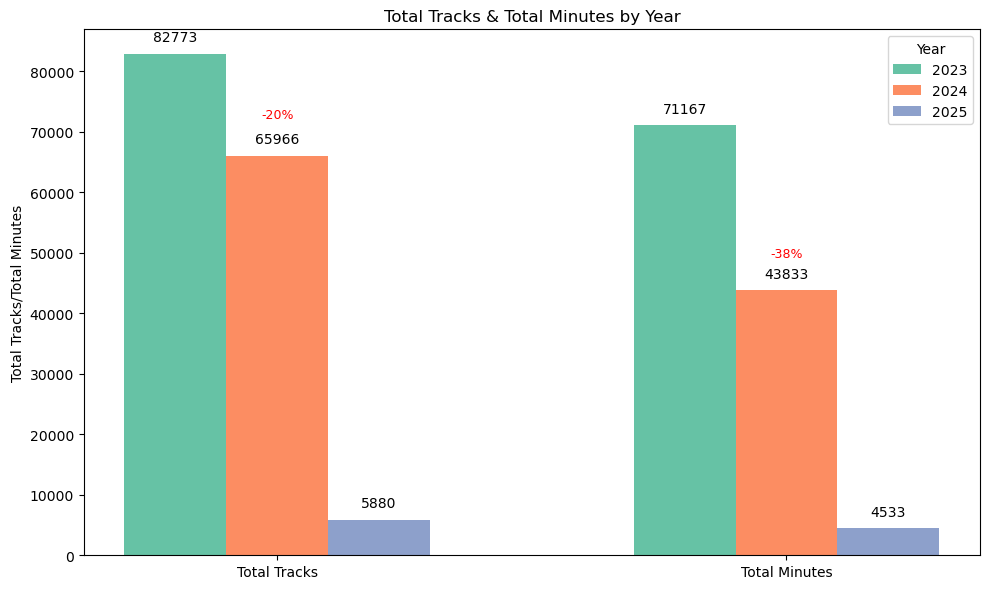

In [ ]:
# Extract year from the aggregated dataframe
years = agg.index.values
metrics1 = ['total_tracks', 'total_minutes']
changes1 = ['change_total_tracks', 'change_total_minutes']

n_years = len(years)
n_groups = len(metrics1)
group_positions = np.arange(n_groups)  

# Width of each bar in the chart
bar_width = 0.2

# Offsets for each year's bar so they don't overlap
offsets = np.linspace(-bar_width, bar_width, n_years)  

# Define color palette
colors = sns.color_palette("Set2", n_years)

fig, ax = plt.subplots(figsize=(10, 6))


# Loop over each year
for i, year in enumerate(years):

    # Loop over each metric
    for j, metric in enumerate(metrics1):
        x_pos = group_positions[j] + offsets[i]
        
        # Retrive the main value
        value = agg.loc[year, metric]

        # Retrieve the year-over-year change
        change_value = agg.loc[year, changes1[j]]
        
        # Plot bar
        ax.bar(x_pos, value, width=bar_width, color=colors[i], label=str(year) if j == 0 else "")
        
        # Calculate offsets to place text slightly above each other
        max_val_for_metric = agg[metric].max()
        val_offset = 0.02 * max_val_for_metric   # small offset for the main value
        pct_offset = 0.07 * max_val_for_metric   # larger offset for the percentage

        # Annotate the main value
        ax.text(x_pos, value + val_offset, f"{value:.0f}",
                ha='center', va='bottom', fontsize=10, color='black')

        # Annotate the percentage change (skip for 2025)
        if not np.isnan(change_value) and int(year) != 2025:
            pct_text = f"{change_value*100:.0f}%"
            color_text = 'green' if change_value > 0 else 'red' if change_value < 0 else 'black'
            ax.text(x_pos, value + pct_offset, pct_text,
                    ha='center', va='bottom', fontsize=9, color=color_text)

# Configure x-axis
ax.set_xticks(group_positions)
ax.set_xticklabels(["Total Tracks", "Total Minutes"])
ax.set_ylabel("Count of Tracks/Sum of Minutes")
ax.set_title("Total Tracks & Total Minutes by Year")
ax.legend(title="Year")
plt.tight_layout()
plt.show()

## Insight for total tracks and total minutes 
- **2023 was the peak year**: The highest bars for both total tracks (82,773) and total minutes (71,167) occur in 2023  
- **Noticeable Drop from 2023 to 2024**: 
    - Totcal tracks decrease by about 20%, from 82,773 down to 65,966. 
    - Total minutes drop even more sharply-- by about 38&, from 71,167 down to 43,833.  
    - This bigger decline in total minutes implies not only fewer tracks played but also shorter listening time per track or fewer overall listening sessions.  
- Since Spotify only has two months of data from 2025, I cannot extract too mnay insights from 2025.

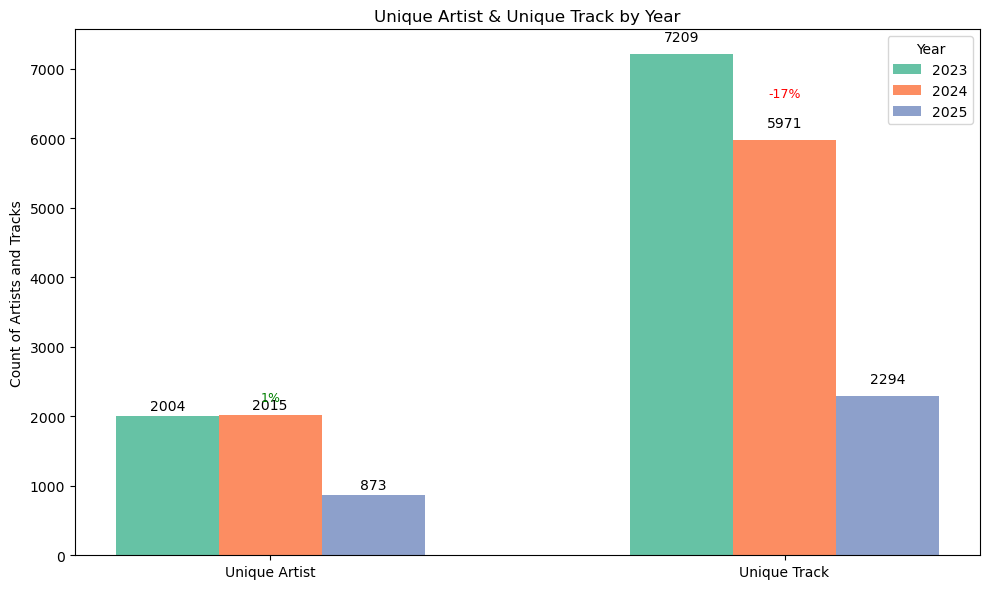

In [23]:
# For unique artist and unique track
metrics2 = ['unique_artist', 'unique_track']
changes2 = ['change_unique_artist', 'change_unique_track']

group_positions = np.arange(len(metrics2))


fig, ax = plt.subplots(figsize=(10, 6))

for i, year in enumerate(years):
    for j, metric in enumerate(metrics2):
        x_pos = group_positions[j] + offsets[i]
        
        value = agg.loc[year, metric]
        change_value = agg.loc[year, changes2[j]]
        
        # Plot bar
        ax.bar(x_pos, value, width=bar_width, color=colors[i], label=str(year) if j == 0 else "")
        
        # Offsets for annotations
        max_val_for_metric = agg[metric].max()
        val_offset = 0.02 * max_val_for_metric
        pct_offset = 0.08 * max_val_for_metric

        # 1) Annotate main value
        ax.text(x_pos, value + val_offset, f"{value:.0f}",
                ha='center', va='bottom', fontsize=10, color='black')

        # 2) Annotate percentage change (skip for 2025)
        if not np.isnan(change_value) and int(year) != 2025:
            pct_text = f"{change_value*100:.0f}%"
            color_text = 'green' if change_value > 0 else 'red' if change_value < 0 else 'black'
            ax.text(x_pos, value + pct_offset, pct_text,
                    ha='center', va='bottom', fontsize=9, color=color_text)

ax.set_xticks(group_positions)
ax.set_xticklabels(["Unique Artist", "Unique Track"])
ax.set_ylabel("Count of Artists and Tracks")
ax.set_title("Unique Artist & Unique Track by Year")
ax.legend(title="Year")
plt.tight_layout()
plt.show()


## Insight for unique artists and unique tracks  
- **Slight Increase in Unique Artists from 2023 to 2024**:
    - The number of unique artists increased about 1% from 2023 to 2024.  
- **Sharp Increase in Unique Tracks from 2023 to 2024**:
    - The number of unique tracks decreased about 17% from 2023 to 2024.  
- **Tracks vs. Artists**:
    - In 2023, I have roughly 3.6 unique tracks per unique artist (7209 tracks / 2004 artists). In 2024, the ratio falls closer to 3.0 (5971 tracks / 2015 artists).
    - This implies I listened to fewer tracks per artist but spread out across more artists.  
- Since Spotify only has two months of data from 2025, I cannot extract too mnay insights from 2025.

### Monthly Listening Hours  
In this session, I will explore the number of hours I streamed on Spotify every year.

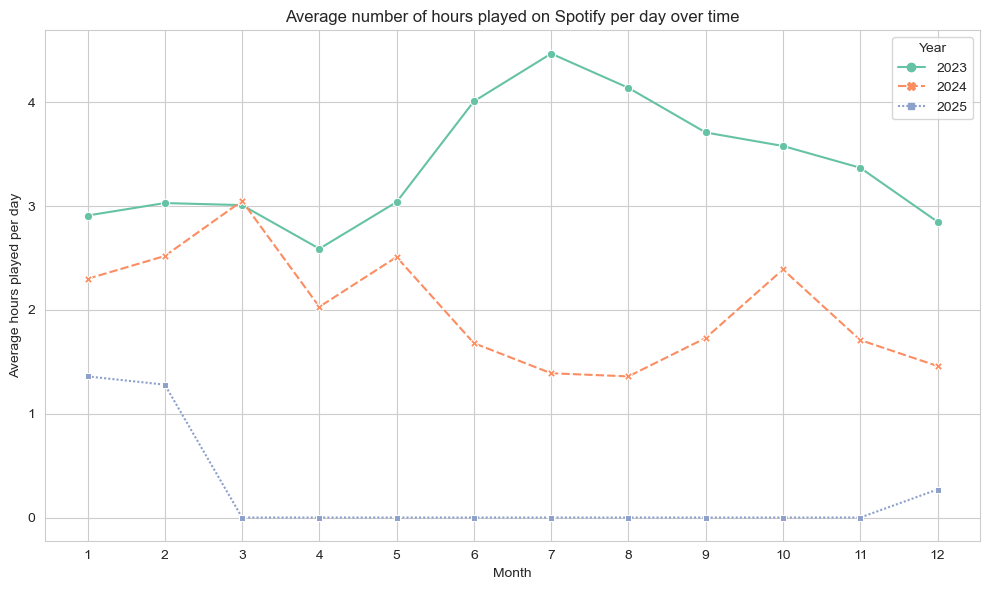

In [25]:
spotify_data['timestamp_target'] = pd.to_datetime(spotify_data['timestamp_target'], utc= True, errors='coerce')
spotify_data['month_num'] = spotify_data['timestamp_target'].dt.month  # Numeric month: 1..12


# Group by year and month
monthly_agg = (
    spotify_data
    .groupby(['year', 'month_num'], as_index=False)
    .agg(
        
        total_min = ('minute_played', 'sum'),          # Total minutes played
        distinct_dates = ('date', 'nunique')           # Number of unique dates
    )
)

# Calculate total hours and average hours played per day
monthly_agg['hours_played'] = monthly_agg['total_min'] / 60.0
monthly_agg['hours_played_day'] = (monthly_agg['hours_played'] / monthly_agg['distinct_dates']).round(2)


years = sorted(monthly_agg['year'].unique())

# Create a complete MultiIndex for (year, month) combinations (months 1 through 12)
full_index = pd.MultiIndex.from_product([years, range(1, 13)], names=['year', 'month_num'])
monthly_agg_full = monthly_agg.set_index(['year', 'month_num']).reindex(full_index).reset_index()

# Fill missing values with 0 so that missing months show as 0 hours played per day.
monthly_agg_full['hours_played_day'] = monthly_agg_full['hours_played_day'].fillna(0)

# Plot graph
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

lineplt = sns.lineplot(
    data=monthly_agg_full,
    x='month_num',
    y='hours_played_day',
    hue='year',       # Different color for each year
    style='year',     # Different line style and marker for each year
    markers=True,
    palette='Set2'
)

lineplt.set_xticks(range(1, 13))  
lineplt.set_title('Average number of hours played on Spotify per day over time')
lineplt.set_xlabel('Month')
lineplt.set_ylabel('Average hours played per day')
plt.legend(title='Year', loc='best')
plt.tight_layout()
plt.show()


### Insight for Average Hours Per Day for Every Month  
- **2023 Leads in Consistency and Peak Listening:**
    - The 2023 line (green) consistently sits above the other years, hovering around 3-4 hours per day across months  
    - This suggests a relatively high and stable level of daily Spotify usage throughout the year, indicating 2023 was likely my most active period.  
- **2024 Shows Moderate Daily Listening:**
    - The 2024 line (red) is lower than 2023 but still maintains a range of roughly 2-3 hours per day.  
    - There's a dip in some months (around April, June and July) follower by recoveries in others.  
    - This pattern suggests slightly less consistent engagement compared to 2023, but still a solid amount of daily listening.
- **2025's Sharp Decline:**
    - Although I only have two months of streaming history data from Spotify for 2025, it's still possible to extract some insights.  
    - The 2025 line (blue) remains significantly lower, averaging 1-2 hours per day.  
- **Month-to-Month Fluctuations** 
    - Each year shows distinct peaks and troughs (e.g. a spike in listneing hours in summer in 2023, but a dip in 2024).  
    - These fluctuations does not align with seasonal patterns, but more likely to personal life events.

### Day of Week Stream  
In this session, I will discover number of minutes I streamed based on day of the week.

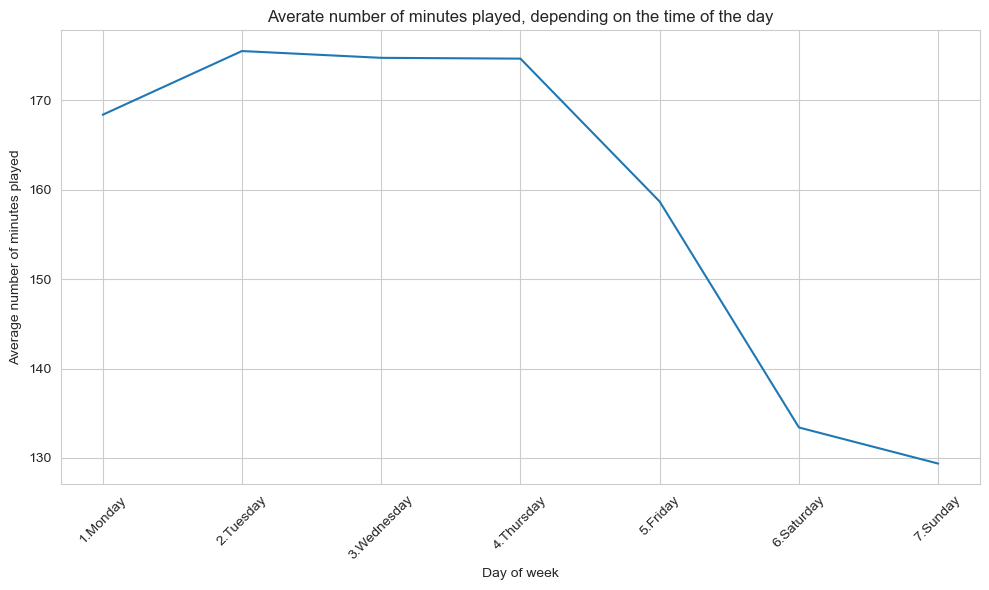

In [ ]:
df=spotify_data
df['weekday_num']=spotify_data['timestamp_target'].dt.weekday+1

# Map numeric weekday to a string with a numeric prefix for ordering
day_mapping = {
    1: '1.Monday',
    2: '2.Tuesday',
    3: '3.Wednesday',
    4: '4.Thursday',
    5: '5.Friday',
    6: '6.Saturday',
    7: '7.Sunday'
}
df['day_of_week'] = df['weekday_num'].map(day_mapping)

# Group by day of week
grouped = df.groupby(['day_of_week']).agg(
    
    unique_dates=('date', 'nunique'),       
    total_min_played=('minute_played', 'sum') 
).reset_index()
grouped['avg_min_played'] = (grouped['total_min_played'] / grouped['unique_dates']).round(2)

# Plot the graph
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

g = sns.lineplot(
    data=grouped.sort_values("day_of_week"),
    x="day_of_week",
    y="avg_min_played",
    markers=True
)
plt.xticks(rotation=45)
plt.title("Averate number of minutes played, depending on the time of the day")
plt.xlabel("Day of week")
plt.ylabel("Average number of minutes played")
plt.tight_layout()
plt.show()

#### Insights for Average Minutes by Day of the Week
- **High Listening Monday to Thursday:**
    - The average number of minutes played is consistently higher on weekdays, especially from Monday to Thursday, around 170 minutes per day.  
    - This pattern might reflect a daily routine, such as commuting or working with background music on weekdays.  
- **Notable Drop Starting Friday:**
    - There's a clear deecline on Friday compared to earlier in the week.
- **Lowest Listening on Saturday and Sunday**
    - The weekend sees the lowest average daily minutes, around 130 minutes.
    - Weekends are filled with other activities, such as outdoor events or social gatherings, leading to reduced listening time.
- **Routine vs. Leisure Pattern:**
    - Overall, the data suggests that my Spotify usage is tied more closely to weekday routines rather than weekend leisure. 
    - In other words, I listen more when I'm in a structured schedule and less during off-days.

### Device
I will explore how many songs I listened to on different platforms every year

Text(0.5, 1.0, 'Number of songs listened on device per year')

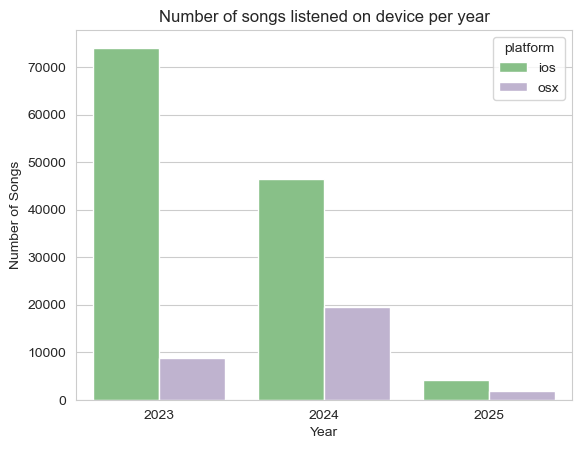

In [ ]:
# Device analysis
device = sns.countplot(data= spotify_data.sort_values("year"), x = "year", hue = "platform", palette = "Accent")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.title("Number of songs listened on device per year")

### Insights for Device Usage
- **IOS Dominates**
    - In each year, IOS accounts for a substantially higher number of songs played than OSX
- **Year-Over-Year Decline:**
    - Both platforms see a noticeable drop over years.
    - This downward trend aligns with the broader pattern seen in previous charts, indicating overall reduced Spotify usage over time.

### Top 10 Tracks  
I will explore the top 10 most streamed tracks based on total minutes I've listened to. I will analyze top 10 tracks of all time, and of every year.

                                             track_name   artist_name  \
7011                                  Say Yes To Heaven  Lana Del Rey   
4939                                          Love song  Lana Del Rey   
7333                                             Snooze           SZA   
5162                         Margaret (feat. Bleachers)  Lana Del Rey   
5002                    Lust For Life (with The Weeknd)  Lana Del Rey   
8435                                  Tulsa Jesus Freak  Lana Del Rey   
4642                       Let Me Love You Like A Woman  Lana Del Rey   
1553                   Chemtrails Over The Country Club  Lana Del Rey   
4643         Let The Light In (feat. Father John Misty)  Lana Del Rey   
2114  Did you know that there's a tunnel under Ocean...  Lana Del Rey   

      total_plays  total_minutes  
7011          456     600.927417  
4939          424     638.226983  
7333          405     640.218267  
5162          405     673.266717  
5002          392    

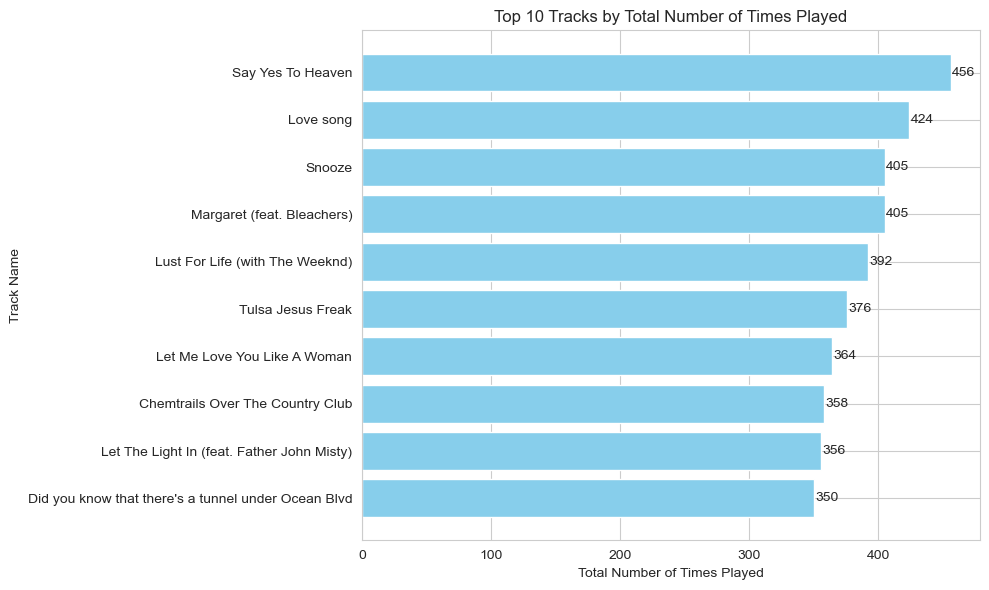

In [ ]:
# Group by track and artist, then calculate total plays and total minutes listened
top_tracks = (
    spotify_data
    .groupby(['track_name', 'artist_name'], as_index=False)
    .agg(
        total_plays=('spotify_track_uri', 'count'),   # Count of plays
        total_minutes=('minute_played', 'sum')          # Total minutes played
    )
)

# Sort descending by total plays and select the top 10
top10_tracks = top_tracks.sort_values(by='total_plays', ascending=False).head(10)

# Display result
print(top10_tracks)

# Plot the graph
plt.figure(figsize=(10, 6))
bars = plt.barh(top10_tracks['track_name'], top10_tracks['total_plays'], color='skyblue')
plt.xlabel("Total Number of Times Played")
plt.ylabel("Track Name")
plt.title("Top 10 Tracks by Total Number of Times Played")

# Invert the y-axis so the highest values are at the top
plt.gca().invert_yaxis()

# Annotate each bar with the minutes played value
for bar, play_count in zip(bars, top10_tracks['total_plays']):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{play_count:.0f}",  # display as an integer
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Insight for Top 10 Tracks of All Time
- **Dominance of One Artist:**
    - The majority of top tracks are by the same artist -- Lana Del Rey, indicating a strong preference to her music, which we will explore further in Top 5 Artists Analysis.
- **Small Range Between Most-Played Tracks:**
    - The highest-played track (466 plays) is not drastically far from the 10th-ranked track (345 plays).
    - This suggests I cycle through these top favorites fairly consistently, rather than replaying just one or two tracks an outsized amount.

       year                                         track_name    artist_name  \
3153   2023                                          Love song   Lana Del Rey   
3191   2023                    Lust For Life (with The Weeknd)   Lana Del Rey   
4478   2023                                  Say Yes To Heaven   Lana Del Rey   
3306   2023                         Margaret (feat. Bleachers)   Lana Del Rey   
4676   2023                                             Snooze            SZA   
5339   2023                                  Tulsa Jesus Freak   Lana Del Rey   
2961   2023                       Let Me Love You Like A Woman   Lana Del Rey   
2182   2023                           Happiness is a butterfly   Lana Del Rey   
978    2023                   Chemtrails Over The Country Club   Lana Del Rey   
2371   2023                                   How to disappear   Lana Del Rey   
11807  2024                                   eternal sunshine  Ariana Grande   
12015  2024                 

/Users/Aprxx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25165 (\N{CJK UNIFIED IDEOGRAPH-624D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Aprxx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Aprxx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21313 (\N{CJK UNIFIED IDEOGRAPH-5341}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Aprxx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


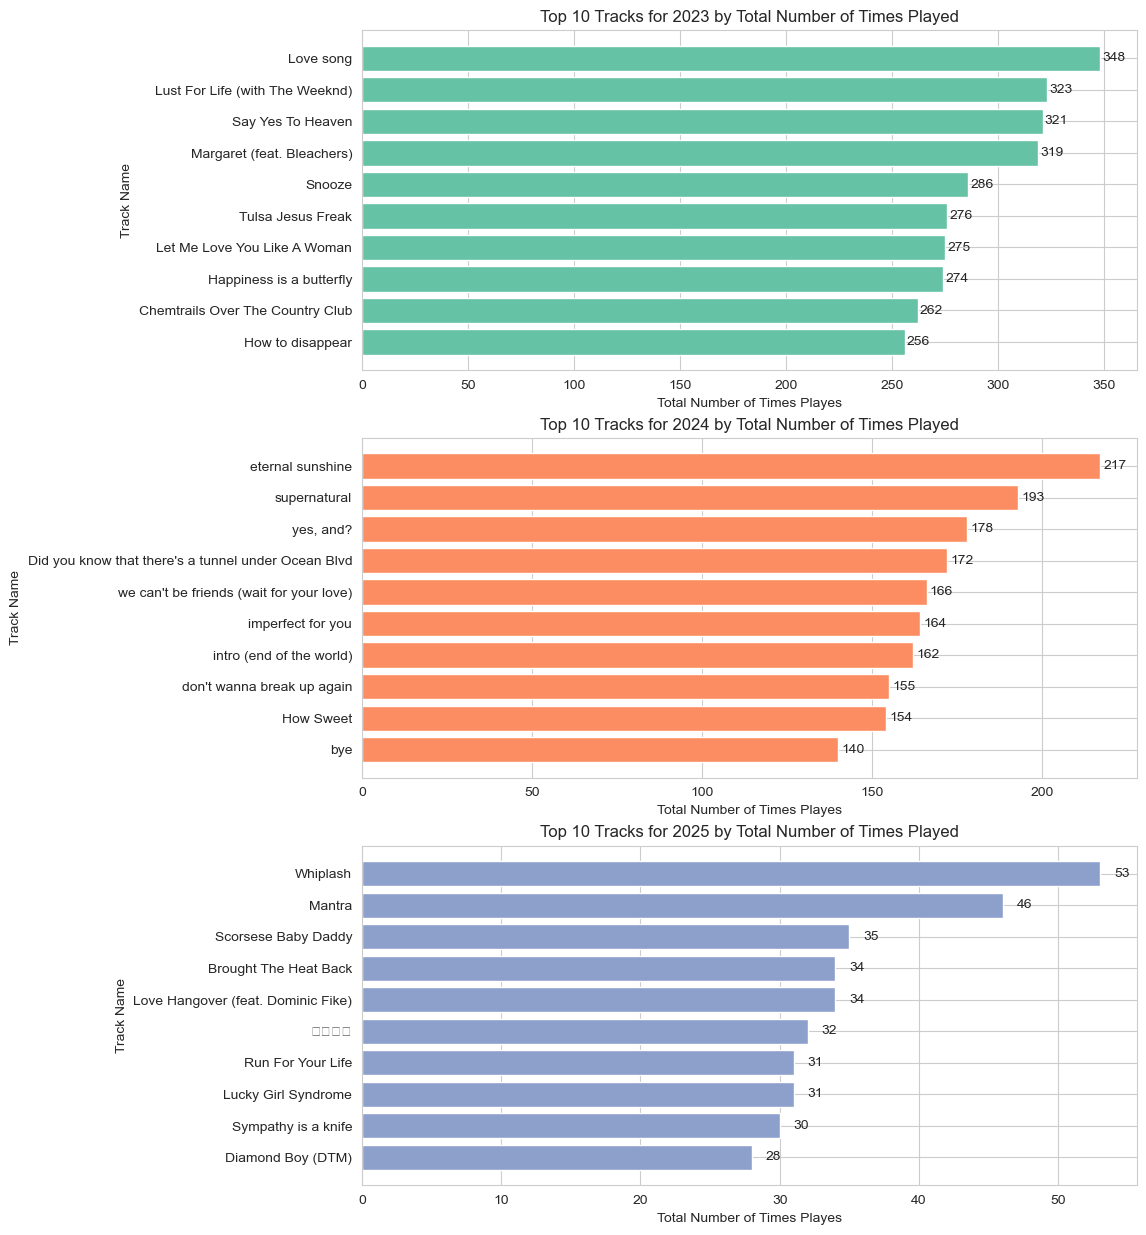

In [ ]:
# Group by year, track, and artist to calculate total plays and total minutes played
top_tracks_year = (
    spotify_data
    .groupby(['year', 'track_name', 'artist_name'], as_index=False)
    .agg(
         total_plays=('spotify_track_uri', 'count'),
         total_minutes=('minute_played', 'sum')  # optional: total time listened
    )
)

# For each year, sort by total plays in descending order and take the top 10 tracks
top10_by_year = (
    top_tracks_year
    .groupby('year', group_keys=False)
    .apply(lambda x: x.sort_values(by='total_plays', ascending=False).head(10))
)

# Display result
print(top10_by_year)

years = sorted(top10_by_year['year'].unique())
palette = sns.color_palette("Set2", len(years))

# Map each year to a unique color
color_mapping = {year: color for year, color in zip(years, palette)}

# Create subplots: one row per year
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 5 * len(years)), sharex=False)

# In case there's only one year, wrap axes into a list
if len(years) == 1:
    axes = [axes]

# Loop over each year and its corresponding axis
for ax, year in zip(axes, years):
    # Filter data for the current year and sort so that the highest total plays is at the top (when inverted)
    data_year = top10_by_year[top10_by_year['year'] == year].sort_values(by='total_plays', ascending=False)
    
    # Create a horizontal bar chart
    bars = ax.barh(data_year['track_name'], data_year['total_plays'], color=color_mapping[year])
    
    # Set titles and labels
    ax.set_title(f"Top 10 Tracks for {year} by Total Number of Times Played")
    ax.set_xlabel("Total Number of Times Played")
    ax.set_ylabel("Track Name")
    
    # Annotate each bar with the total plays value
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2, f"{int(width)}", va='center', fontsize=10)
    
    
    ax.invert_yaxis()


plt.show()

### Insights for Top 10 Tracks Each Year
- **2023 - A Dominant Theme:**
    - The 2023 top 10 list is heavily populated by songs from Lana Del Rey.
    Play counts are fairly high (all in the 250+ range), indicating I frequently returned to these tracks throughout the year.  
- **2024 - A Shift in Favorites:**
    - Unlike 2023, I shifted to a new artist-- Ariana Grande.
    - The top track has a lower total count (217 plays) than 2023's top track (304 plays), which aligns with the decline in overall listening using Spotify.  
- **2025 - Different Genre:**
    - Since I only have 2 months of data for 2025, the total number of plays significantly decline.
    - My top tracks are shifted to a new genre -- Kpop.

### Top 5 Artists
I will explore my top 5 artists based on the total hours I've listened to. I will analyze top 5 artists of all time, and of every year.

Top 5 artists of all time:
        artist_name  total_minutes  total_hours
1621   Lana Del Rey   22313.058000   371.884300
2434            SZA    5125.028350    85.417139
2694   Taylor Swift    4219.054100    70.317568
204   Ariana Grande    3830.708917    63.845149
2040       NewJeans    2368.889617    39.481494


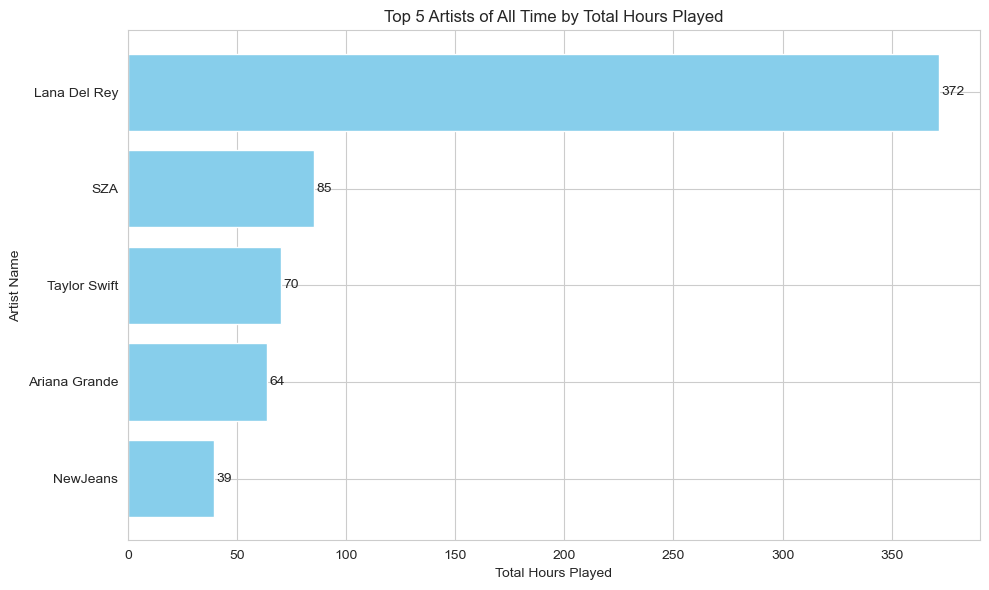

In [ ]:
# Group by artist
top_artists_all_time = (
    spotify_data
    .groupby('artist_name', as_index=False)
    .agg(
        
        total_minutes=('minute_played', 'sum')
        
    )
    .sort_values('total_minutes', ascending=False)
    .head(5)
)

# Convert minutes to hours
top_artists_all_time['total_hours'] = top_artists_all_time['total_minutes']/60

# Display Result
print("Top 5 artists of all time:")
print(top_artists_all_time)

# Plot the graph
plt.figure(figsize=(10, 6))
bars = plt.barh(top_artists_all_time['artist_name'], top_artists_all_time['total_hours'], color='skyblue')
plt.xlabel("Total Hours Played")
plt.ylabel("Artist Name")
plt.title("Top 5 Artists of All Time by Total Hours Played")

# Invert the y-axis so the highest values are at the top
plt.gca().invert_yaxis()

# Annotate each bar with the minutes played value
for bar, play_count in zip(bars, top_artists_all_time['total_hours']):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{play_count:.0f}",  # display as an integer
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Insights for Top 5 Artists of All Time
- **One Artist Dominates:**
    - Lana Del Rey stands out with around 372 total hours played-- far surpassing the second-place artist, which aligns with my top 10 tracks of all time.
- **Tiered Second-Through-Fifth:**
    - The remaining four artists cluster within a narrower range (39-85 hours).
    - While I've invested a decent amount of time in each of these artists, none approach the total hours dedicated to my top artist.

Top 5 artists for each year:
      year    artist_name  total_minutes  total_hours
982   2023   Lana Del Rey   15284.494033   254.741567
1470  2023            SZA    2577.654933    42.960916
1623  2023   Taylor Swift    2131.822767    35.530379
1661  2023     The Weeknd    1664.614017    27.743567
1155  2023   Metro Boomin    1562.863900    26.047732
2953  2024   Lana Del Rey    6938.508617   115.641810
2106  2024  Ariana Grande    3023.511850    50.391864
3452  2024            SZA    2094.741567    34.912359
3617  2024   Taylor Swift    2063.356750    34.389279
2291  2024     Cheer Chen    1467.241733    24.454029
4652  2025            SZA     452.631850     7.543864
4817  2025          aespa     290.662483     4.844375
4212  2025        ENHYPEN     155.131083     2.585518
4144  2025     Charli xcx     139.114033     2.318567
4889  2025            阿弗娄     131.509767     2.191829


/Users/Aprxx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38463 (\N{CJK UNIFIED IDEOGRAPH-963F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Aprxx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24343 (\N{CJK UNIFIED IDEOGRAPH-5F17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Aprxx/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23044 (\N{CJK UNIFIED IDEOGRAPH-5A04}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


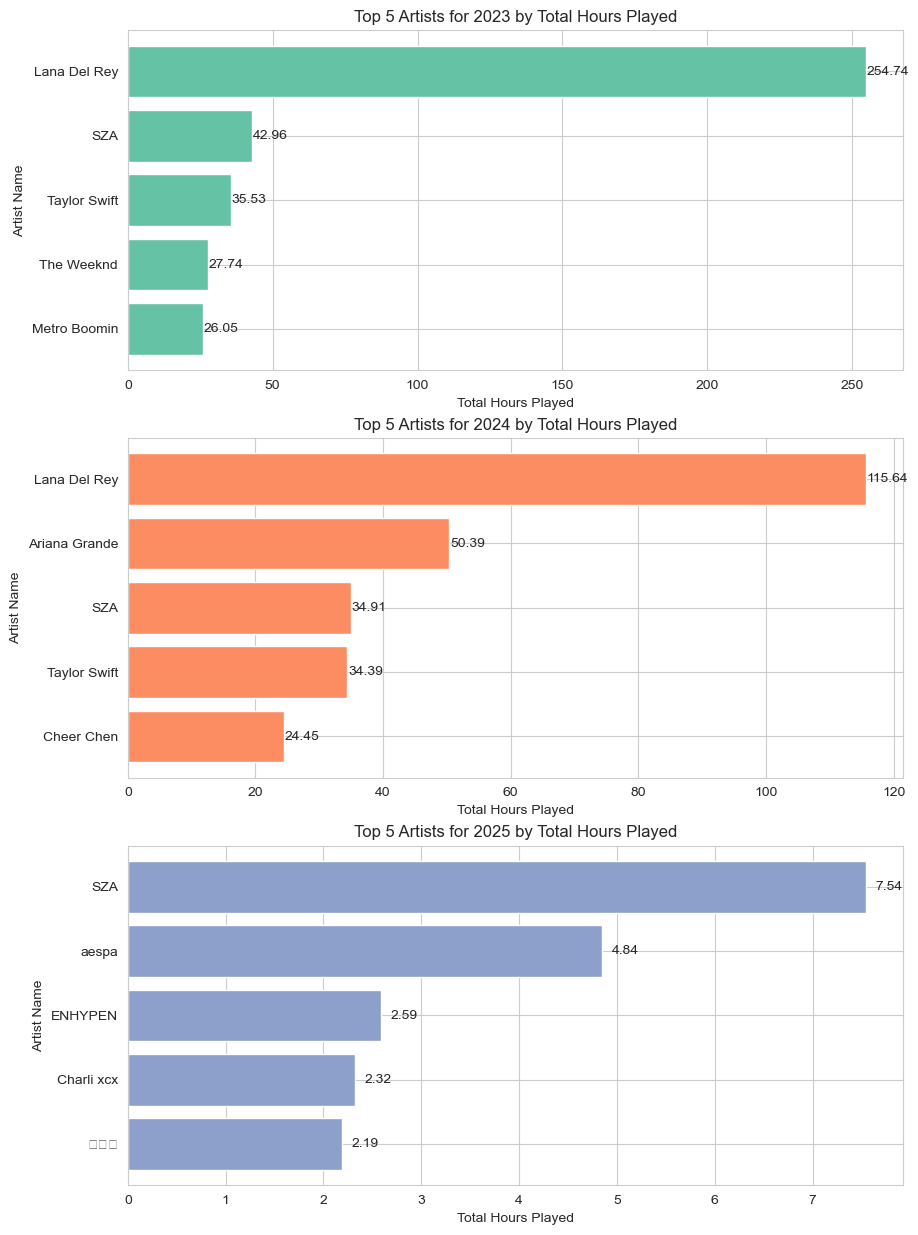

In [ ]:
# Group by year
top_artists_year = (
    spotify_data
    .groupby(['year', 'artist_name'], as_index=False)
    .agg(
        
        total_minutes=('minute_played', 'sum')
    )
)
# Convert minutes to hours
top_artists_year['total_hours']= top_artists_year['total_minutes']/60


# For each year, sort by total plays descending and take the top 5 artists
top5_artists_year = top_artists_year.groupby('year', group_keys=False)\
    .apply(lambda x: x.sort_values('total_hours', ascending=False).head(5))

# Display result
print("Top 5 artists for each year:")
print(top5_artists_year)

years = sorted(top10_by_year['year'].unique())
palette = sns.color_palette("Set2", len(years))

# Map each year to a unique color
color_mapping = {year: color for year, color in zip(years, palette)}

# Create subplots: one row per year
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 5 * len(years)), sharex=False)

# In case there's only one year, wrap axes into a list
if len(years) == 1:
    axes = [axes]

# Loop over each year and its corresponding axis
for ax, year in zip(axes, years):
    # Filter data for the current year and sort by total hours descending
    data_year = top5_artists_year[top5_artists_year['year'] == year].sort_values(by='total_hours', ascending=False)
    
    # Escape dollar signs in artist names so they are interpreted as literal characters
    artist_names = data_year['artist_name'].apply(lambda x: x.replace('$', r'\$'))
    
    # Create a horizontal bar chart using the escaped artist names as tick labels
    bars = ax.barh(artist_names, data_year['total_hours'], color=color_mapping[year])
    
    # Set titles and labels
    ax.set_title(f"Top 5 Artists for {year} by Total Hours Played")
    ax.set_xlabel("Total Hours Played")
    ax.set_ylabel("Artist Name")
    
    # Annotate each bar with the total hours value (formatted to 2 decimals)
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f"{width:.2f}",
                va='center', fontsize=10)
    # Optionally, invert the y-axis so the highest plays appear at the top
    ax.invert_yaxis()


plt.show()

### Insights for Top 5 Artists Each Year
- **2023 - Lana Del Rey's Dominance:**
    - Lana Del Rey tops the list with aronud 255 hours, overshadowing other artists.
    - The gap between first and second place is very large, reflecting a strong preference for Lana Del Rey's discography in 2023.
- **2024 - Decline but Continued Focus:**
    - Lana Del Rey remains in first place (around 116 hours), but her total hours are less than half of 2023's.
    - Ariana Grande (50 hours) enters the list at second, which aligns with the pattern of my top 10 tracks in 2024.
    - This suggests a slight broadening of listening habits compared to 2023, with more time dedicated to new or different artists. 
- **2025 - Big Shift in Artists:**
    - Since I only have 2 months of data for 2025, the total number of hours played significantly decline.
    - Lana Del Rey and other prior-year favorites don't even appear in the top 5 of 2025, indicating a major change in my listening behavior.
    - The introduction of aespa and ENHYPEN signals a shift toward new genres (Kpop).